## Klimadynamics 2

Nils and Rovina

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from scipy.linalg import det, inv, eig
from numpy.random import normal as norm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import pearsonr

### Part 1

Read HadSLP2 (Allan & Ansell, 2006) gridded global sea level pressure (SLP)anomalies from 1850 to 2004. We want to explore SLP variability at the locations Lisbon (Portugal) and Reykjavik (Island), which are important SLP time series for the definition of the so-called Hurrell-index (Hurrell, 1995) for the North AtlanticOscillation (NAO).

- Read HadSLP2 data set and extract the December months (alternatively youmay average over the December to February (DJF) season). Plot the long term mean SLP field for December (or DJF).

- Extract the December (DJF) SLP values at the grid box including Lisbon ($38^\circ 43'$ N, $9^\circ 10'$ W), Portugal and Stykkisholmur/Reykjavik ($64^\circ 7'$ N, $21^\circ 54'$W), Iceland, respectively. Put the two time series into an array with a similarform as the bivariate sample generated in Exercise I.

- Plot a 2D-histogram (use respective program from Exercise I) to visualize a non-parametric estimate of the bivariate PDF.

- Estimate the parameters of a bivariate normal distribution, i.e. mean, variance and correlation/covariance and plot respective Gaussian PDF (use program from Exercise I). Compare both estimates of the bivariate PDF.

In [2]:
!ncdump -h HadSLP2_slp-mnmean-real.nc

netcdf HadSLP2_slp-mnmean-real {
dimensions:
	lon = 72 ;
	lat = 37 ;
	nbnds = 2 ;
	time = UNLIMITED ; // (2033 currently)
variables:
	float lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
		lat:actual_range = 90.f, -90.f ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:coordinate_defines = "center" ;
	float lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
		lon:actual_range = 0.f, 355.f ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
		lon:coordinate_defines = "center" ;
	double time(time) ;
		time:units = "days since 1800-1-1 00:00:00" ;
		time:long_name = "Time" ;
		time:actual_range = 18262., 80322. ;
		time:delta_t = "0000-01-00 00:00:00" ;
		time:avg_period = "0000-01-00 00:00:00" ;
		time:prev_avg_period = "0000-00-01 00:00:00" ;
		time:standard_name = "time" ;
		time:axis = "T" ;
	double time_bnds(time, nbnds) ;
		time_bnds:long_name = "Time Boundaries" ;
	float slp(time, lat, lon) ;
		slp:long_name = "Mont

In [3]:
with xr.open_dataset("HadSLP2_slp-mnmean-real.nc") as ds:
    print(ds.keys())

KeysView(<xarray.Dataset>
Dimensions:    (lat: 37, lon: 72, nbnds: 2, time: 2033)
Coordinates:
  * lat        (lat) float32 90.0 85.0 80.0 75.0 ... -75.0 -80.0 -85.0 -90.0
  * lon        (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    slp        (time, lat, lon) float32 ...
Attributes:
    title:        HadSLP2 Real-Time
    history:      Created 02/2006 by CAS
    comments:     adSLP2 was created using marine observations taken from ICO...
    Conventions:  CF-1.0
    platform:     Model
    source:       Hadley Center
    institution:  Hadley Center
    References:   https://hadobs.metoffice.com/gmslp/hadslp2/\nhttps://psl.no...)


In [4]:
ds.slp

<xarray.DataArray 'slp' (time: 2033, lat: 37, lon: 72)>
[5415912 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 85.0 80.0 75.0 70.0 ... -75.0 -80.0 -85.0 -90.0
  * lon      (lon) float32 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2019-12-01
Attributes:
    long_name:             Monthly Mean Sea Level Pressure
    unpacked_valid_range:  [ 850. 1400.]
    actual_range:          [ 948.8  1052.51]
    units:                 mb
    precision:             1
    var_desc:              Sea Level Pressure
    dataset:               HadSLP2 Real-Time
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Individual Observation
    valid_range:           [ 900. 1500.]

In [5]:
ds_lisbon = ds.sel(lat=40,lon=(360-10), time=ds['time.season']=='DJF').groupby('time.year').mean()
ds_rekja = ds.sel(lat=65,lon=(360-20), time=ds['time.season']=='DJF').groupby('time.year').mean()

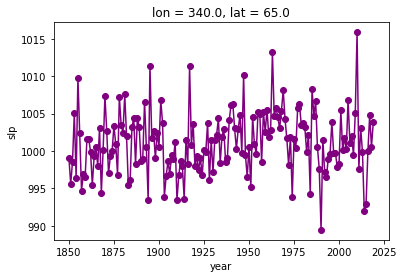

In [6]:
ds_rekja.slp.plot.line(color="purple", marker="o")

Text(0, 0.5, 'Sea level pressure (mb)')

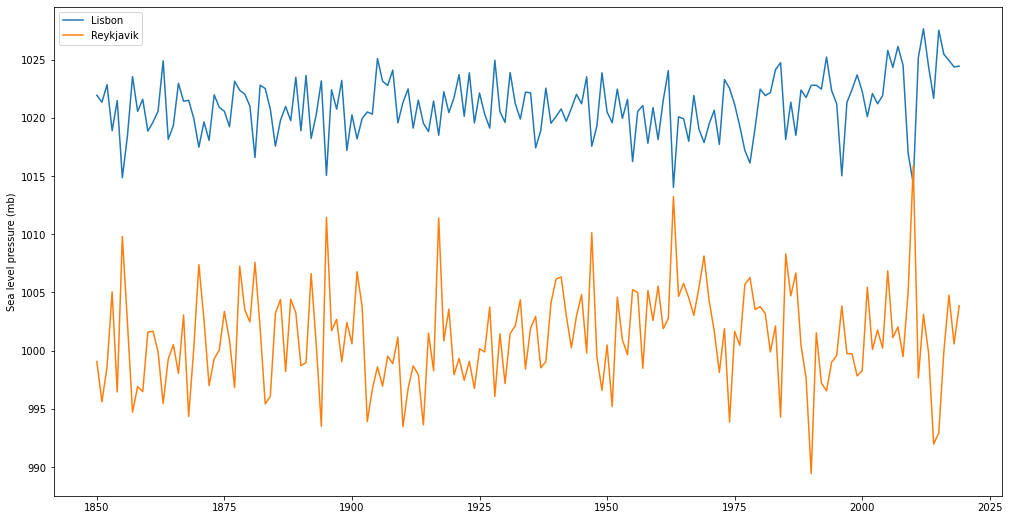

In [7]:
fig = plt.figure(figsize=(17,9))
ax = fig.add_subplot(111)
ax.plot(ds_lisbon["year"],ds_lisbon["slp"], label='Lisbon')
ax.plot(ds_rekja["year"],ds_rekja["slp"], label='Reykjavik') 
plt.legend()
plt.ylabel("Sea level pressure (mb)")

In [8]:
xmin = np.min([ds_lisbon["slp"], ds_rekja["slp"]])
xmax = np.max([ds_lisbon["slp"], ds_rekja["slp"]])

grid = np.array([np.linspace(xmin, xmax, 30), 
                 np.linspace(xmin, xmax, 30)])

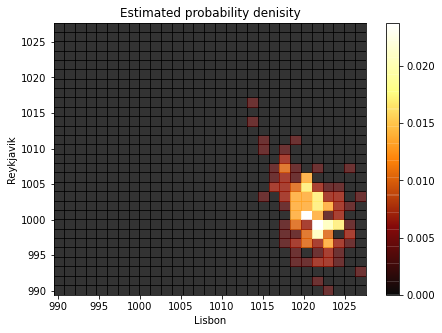

In [9]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
hs = ax.hist2d(ds_lisbon.slp, ds_rekja.slp, bins=grid, cmap='afmhot', density=True, alpha=0.8)
ax.set_xlabel('Lisbon')
ax.set_ylabel('Reykjavik')
ax.set_title('Estimated probability denisity')
fig.colorbar(hs[3]) 
plt.show()

In [10]:
def get_multivariate_normal(x, mu, cov_mat):
    """
    Gaussian multivariate PDF
    
    x:          array with elements of random variable (dim: q)
    mu:         array with mean of random variable (dim: q)
    cov_mat:    covariance matrix (dim: q x q)
    """
    
    q = cov_mat.shape[0]
    
    Z = np.sqrt((2*np.pi)**q*det(cov_mat))
    
    prob = 1/Z * np.exp(-0.5*(x-mu).T @ inv(cov_mat) @ (x-mu))
    
    return prob

In [11]:
def est_cov_mat(x1, x2):
    """
    np.cov(slp_lis.values, slp_rey.values)
    """

    m = len(x1)
    
    assert m == len(x2)
    
    mu1 = 1/m * np.sum(x1)
    mu2 = 1/m * np.sum(x2)
    
    mu = np.array([mu1, mu2])
    
    d_1 = x1 - mu1
    d_2 = x2 - mu2
    
    D = np.array([d_1, d_2])
    
    cov_mat = 1/m * np.inner(D, D)
    
    return cov_mat, mu

In [12]:
slp_all = ds.slp.sel(time=ds['time.season'] == 'DJF').groupby('time.year').mean() 
m = len(slp_all.year)

In [13]:
# estimate parameters
# set values
mu = est_cov_mat(ds_lisbon.slp, ds_rekja.slp)[1]

# covariance matrix
cov_mat = est_cov_mat(ds_lisbon.slp, ds_rekja.slp)[0]

# create meshgrid of x1 and x2 
x1_mesh, x2_mesh = np.meshgrid(grid[0, :], grid[1, :])

In [14]:
prob = np.apply_along_axis(get_multivariate_normal, 0, np.array([x1_mesh,x2_mesh]), mu, cov_mat)

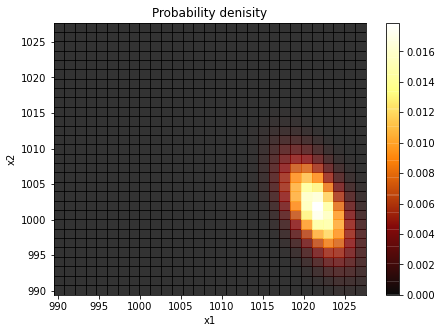

In [15]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
im = ax.pcolormesh(grid[0, :], grid[1, :], prob, shading='nearest', cmap='afmhot', alpha=0.8)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Probability denisity')
fig.colorbar(im)
plt.show()

### Part 2

Calculate global SLP correlation pattern with respect to the principal component(A) related to the first eigenvector of the covariance matrix of the bivariate SLP vector Lisbon and Reykjavik.

- Calculate eigenvectors and calculate the weights (A), sometimes also called expansion coefficients or principal components. How does the first eigenvector look like and what does it tell us?

- Use the weights (A) of the first eigenvector and perform a correlation with the time series at each grid point, respectively. This gives you a field with same spatial dimensions as SLP with correlations. Plot this field. What do you see?

In [16]:
l, E = eig(cov_mat)  # eigen_val, eigen_vec
l = np.sort(l)[::-1]
E = np.array([E[:, 1], E[:,0]])  # reorder as eig doesn't necessarily return ordered values

In [17]:
# calculate principle components (A) using the time series as X
X = np.array([ds_lisbon.slp, ds_rekja.slp])
A = E.T @ X  # principal components

In [22]:
print(np.var(A, axis=1), l)

[19.4466701   4.06268025] [19.4466701 +0.j  4.06268026+0.j]


In [18]:
# calculate sea level pressure correlation field
corr = np.zeros(shape=(len(slp_all.lon), len(slp_all.lat)))
p_value = np.zeros(shape=(len(slp_all.lon), len(slp_all.lat)))
for i, lon in enumerate(slp_all.lon):
    for j, lat in enumerate(slp_all.lat):
            corr[i, j], p_value[i, j] = pearsonr(slp_all.sel(lon=lon, lat=lat), A[0, :]) # use the weights of the first eigen vector

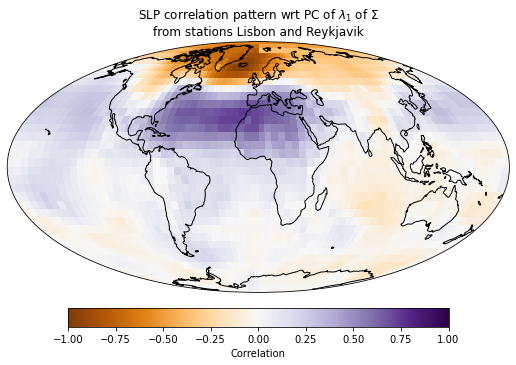

In [19]:
# plot correlation on map
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
ax.set_title('SLP correlation pattern wrt PC of $\lambda_1$ of $\Sigma$\nfrom stations Lisbon and Reykjavik')
ax.set_global()
ax.coastlines()
corr_val, ll = add_cyclic_point(corr.T, coord= ds.lon)
im = ax.pcolormesh(ll, ds.lat, corr_val, transform=ccrs.PlateCarree(), cmap='PuOr', vmin=-1, vmax=1)
fig.colorbar(im, ax=ax, shrink=0.8, fraction=0.05, pad=0.04,label='Correlation',orientation='horizontal')
plt.show()